## Call Rate Benchmark

This notebook benchmarks performance of simple call rate QC operations defined in [Marees et al. 2018](https://www.ncbi.nlm.nih.gov/pubmed/29484742). This step was chosen because it was the subject of performance discussions relating to how slow the same step is when executed via Glow or Hail (over Spark).  The relevant Glow discussion is [here](https://github.com/projectglow/glow/issues/148) and the Hail discussion [here](https://discuss.hail.is/t/poor-performance-for-qc-filtering-on-medium-sized-genotype-data/1263/21).

Below, the same operations on 1KG data that take 3 hours with Glow, 3-4 minutes with Hail, an 35 seconds with PLINK also take about 35 seconds with Xarray over Dask.

In [1]:
import sys
sys.path.append(".")
from lib import api
from lib.io import plugins
from pathlib import Path
import warnings
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.distributed import performance_report
%run nb/paths.py
xr.set_options(display_style='html');

In [2]:
from dask.distributed import Client
client = Client(processes=True, n_workers=8, threads_per_worker=1)
client.register_worker_plugin(plugins.create_dask_codec_plugin())
client

Client Scheduler: tcp://127.0.0.1:42717 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 134.78 GB


In [3]:
# Path to PLINK dataset for demonstration
# path = PLINK_HAPMAP_PATH_01
path = PLINK_1KG_PATH_01
path

PosixPath('/lab/data/gwas/tutorial/2_PS_GWAS/ALL.2of4intersection.20100804.genotypes')

### Export to Zarr

This step will load the PLINK dataset and write it back out to Zarr for more efficient downstream operations.

In [4]:
%%time
# Load a dataset to work with
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
ds

CPU times: user 3.66 s, sys: 396 ms, total: 4.06 s
Wall time: 28 s


,Array,Chunk
Bytes,16.03 GB,134.22 MB
Shape,"(25488488, 629)","(213382, 629)"
Count,241 Tasks,120 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,16.03 GB,134.22 MB
Shape,"(25488488, 629)","(213382, 629)"
Count,241 Tasks,120 Chunks
Type,bool,numpy.ndarray
,Array,Chunk


In [5]:
%%time
# TODO: How can we infer fixed dtypes for strings on load?
# TODO: Set consistent chunk sizes on read

# Match bim/fam arrays to chunks in `data`
chunks = dict(zip(['variant', 'sample'], ds.data.data.chunksize)) 
with warnings.catch_warnings():
    # Ignore:
    #    SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
    warnings.filterwarnings(action='ignore', category=xr.conventions.SerializationWarning)
    # Rechunk so all da.Arrays have same chunk size to avoid:
    #    ValueError: Zarr requires uniform chunk sizes except for final chunk. Variable dask chunks ((2592741, 2590097, 2563466, 2607671, 2595721, 2594521, 2502277, 2513299, 2563743, 2364952),) are incompatible. Consider rechunking using `chunk()`.
    print('Rechunking to:', chunks)
    api.write_zarr(ds.chunk(chunks=chunks), f'/tmp/{path.name}.zarr', mode='w')

Rechunking to: {'variant': 213382, 'sample': 629}
CPU times: user 31.8 s, sys: 4.23 s, total: 36 s
Wall time: 1min 34s


Compare the resulting file sizes, noting that for 1KG the enitre zarr dataset is substantially smaller than the PLINK `.bed` file alone.  This is due to a custom bitpacking filter added by the API as well as default compression options in Zarr.

In [6]:
!du -sh {path}.bed

3.8G	/home/eczech/data/gwas/tutorial/2_PS_GWAS/ALL.2of4intersection.20100804.genotypes.bed


In [7]:
!du -sh /tmp/{path.name}.zarr

2.4G	/tmp/ALL.2of4intersection.20100804.genotypes.zarr


Reload the Zarr dataset for further processing:

In [8]:
ds = xr.open_zarr(f'/tmp/{path.name}.zarr')
ds

,Array,Chunk
Bytes,203.91 MB,1.59 MB
Shape,"(25488488,)","(199129,)"
Count,129 Tasks,128 Chunks
Type,object,numpy.ndarray
,Array,Chunk
Bytes,203.91 MB,1.59 MB
Shape,"(25488488,)","(199129,)"
Count,129 Tasks,128 Chunks
Type,object,numpy.ndarray
,Array,Chunk


### Call Rate

Show call rate for each sample by contig:

In [9]:
def call_rate(ds, dim):
    return 1 - ds.is_masked.mean(dim=dim)

In [10]:
%%time
# TODO: Figure out why grouping by values along variant dimension is so sloooow
df = ds.groupby('contig').map(call_rate, dim='variant').to_pandas()

CPU times: user 1min 25s, sys: 1.99 s, total: 1min 27s
Wall time: 1min 28s


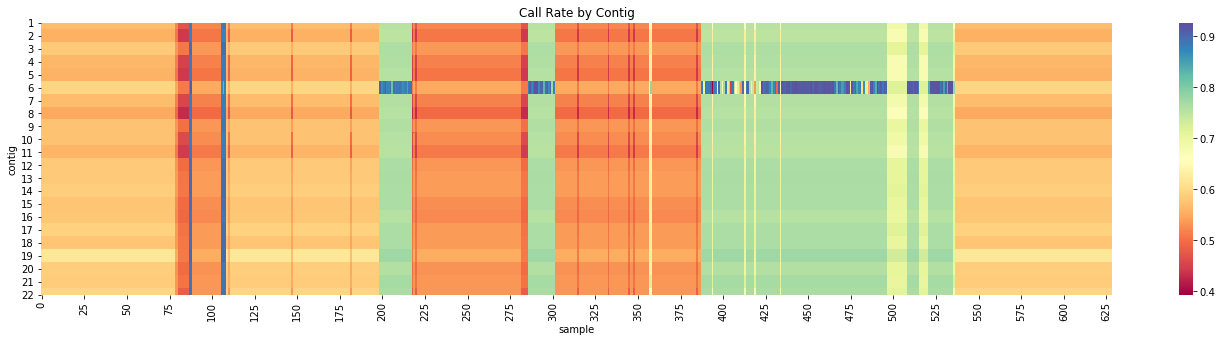

In [11]:
# Note: This missingness on chr 6 for some samples is interesting (HLA?)
ax = sns.heatmap(df, cmap='Spectral', robust=False, yticklabels=1)
ax.set_title('Call Rate by Contig')
plt.gcf().set_size_inches(24, 5)

Benchmark Marees et al. 2018 call rate QC:

In [12]:
def call_rate(ds, dim):
    return 1 - ds.is_masked.mean(dim=dim)

def filter_by_variant_call_rate(ds, threshold):
    return ds.sel(variant=call_rate(ds, dim='sample') >= threshold)

def filter_by_sample_call_rate(ds, threshold):
    return ds.sel(sample=call_rate(ds, dim='variant') >= threshold)

def qc(ds):
    ds = filter_by_variant_call_rate(ds, .8)
    ds = filter_by_sample_call_rate(ds, .8)
    ds = filter_by_variant_call_rate(ds, .98)
    ds = filter_by_sample_call_rate(ds, .98)
    return ds

In [13]:
# Expected 1KG shape: (8240745, 629)
# Expected HapMap shape: (1430443, 165)
with performance_report('dev/profiling/reports/call_rate_qc.html'):
    res = %time qc(ds)
res

CPU times: user 12.1 s, sys: 1.53 s, total: 13.6 s
Wall time: 33.5 s


,Array,Chunk
Bytes,65.93 MB,591.52 kB
Shape,"(8240745,)","(73940,)"
Count,385 Tasks,128 Chunks
Type,object,numpy.ndarray
,Array,Chunk
Bytes,65.93 MB,591.52 kB
Shape,"(8240745,)","(73940,)"
Count,385 Tasks,128 Chunks
Type,object,numpy.ndarray
,Array,Chunk
